# One Shot Learning with Siamese Networks

Adapted from: https://github.com/harveyslash/Facial-Similarity-with-Siamese-Networks-in-Pytorch

In this notebook, we will be using a Siamese Network to perform a image verification task on the Omniglot dataset. Given two images, we will determine if they belong to the same class. 

## Imports

In [1]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Helper functions

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
training_dir = "./data/training/"
testing_dir = "./data/testing/"
train_batch_size = 64
train_number_epochs = 100

## Custom Dataset Class
This dataset returns a pair of images and a label 1 if they belong to different classes, or 0 if they belong to the same class. The images are chosen so roughly 50% of the images in a pair belong to the same class.

In [4]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self, imageFolderDataset):
        self.imageFolderDataset = imageFolderDataset   
        self.images = np.array(list(map(list, self.imageFolderDataset.imgs)))
        self.i = 0
        
    def __getitem__(self,index):
        img0_tuple = random.choice(self.images)
        #we need to make sure approx 50% of images are in the same class
        should_get_same_class = random.randint(0,1)
        if should_get_same_class:
            ind = random.choice(np.where(self.images[:,1] == img0_tuple[1])[0])
            img1_tuple = self.images[ind]
        else:
            img1_tuple = random.choice(self.images)

        
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
        
        img0 = transform(img0)
        img1 = transform(img1)

        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

## Using Image Folder Dataset

In [5]:
folder_dataset = dset.ImageFolder(root=training_dir)

In [6]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset)

## Visualising some of the data
The top row and the bottom row of any column is one pair. The 0s and 1s correspond to the column of the image.
0 indiciates dissimilar, and 1 indicates similar.

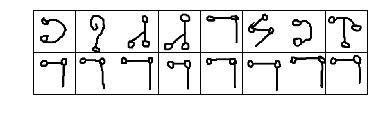

[[1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]


In [7]:
vis_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=8)
dataiter = iter(vis_dataloader)

example_batch = next(dataiter)
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Neural Net Definition
We will use a standard convolutional neural network with the following structure (Note the input image has 1 channel):
*  Reflection padding to maintain size
*  Conv Layer with 4 3x3 kernels
*  ReLU
*  BatchNorm - takes in number of features (number of output channels of conv layer)

*  Reflection padding to maintain size
*  Conv Layer with 8 3x3 kernels
*  ReLU
*  BatchNorm

*  Reflection padding to maintain size
*  Conv Layer with 8 3x3 kernels
*  ReLU
*  BatchNorm


The Conv2d function takes in as input: number of input channels, number of filters (number of output channels), kernel size.


Then we will be adding some fully connected layers to bring each image into a 5 dimensional feature space.

#### TODO:
The first set of layers in the CNN have been added. Using those as reference for syntax, fill in the rest of the layers.

Think about what the forward pass of this network should do. What should the inputs and outputs be?

In [8]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        """
        TODO: Fill in the remaining layers of the CNN
        """
        super(SiameseNetwork, self).__init__()
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1), # padding with values at edges being reflected
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),

            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),
        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        """
        TODO: Think about how given an input we can appropriately run it through the network. 
        Is there something we have to do between the convolution and fully connected layers?
        """
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1) # reshaping
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        """
        TODO: Using the forward_once function (which runs the conv and fully connected layers on a single input)
        what should the forward pass of the overall network do? Refer back to the diagram of a Siamese network
        and think about the inputs and outputs.
        """
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        euclidean_distance = F.pairwise_distance(output1, output2)
        return euclidean_distance

## Contrastive Loss

The contrastive loss function takes in 

1) The pairwise distance between two images

2) Label representing if the images are same (0) or different (1)

#### TODO:
Implement the loss function:
$$L(d, y) = (1-y)*d^2 + y*(\max(\alpha - d, 0))^2$$

Hints:
* Use torch.pow(input, exponent) to square a tensor
* Use torch.clamp(input, min=...) or torch.clamp(expression, max=...) to cut off the values of an input at some min or max value
* Remember: The input will be given as a batch, but we want a single scalar for the loss

In [9]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=5.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, euclidean_distance, label):
        """
        TODO: Implement the loss function above
        """
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training Time!

In [10]:
train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=train_batch_size)

In [11]:
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005)

In [12]:
counter = []
loss_history = [] 
iteration_number= 0

Epoch number 0
 Current loss 22.433549880981445

Epoch number 1
 Current loss 25.555986404418945

Epoch number 2
 Current loss 3.676987648010254

Epoch number 3
 Current loss 6.847812652587891

Epoch number 4
 Current loss 2.707871913909912

Epoch number 5
 Current loss 3.6312508583068848

Epoch number 6
 Current loss 1.8701753616333008

Epoch number 7
 Current loss 0.5429127812385559

Epoch number 8
 Current loss 1.8864848613739014

Epoch number 9
 Current loss 0.6373158097267151

Epoch number 10
 Current loss 1.8121246099472046

Epoch number 11
 Current loss 1.1992892026901245

Epoch number 12
 Current loss 0.8398733735084534

Epoch number 13
 Current loss 0.5792741775512695

Epoch number 14
 Current loss 0.647585391998291

Epoch number 15
 Current loss 0.569573700428009

Epoch number 16
 Current loss 1.36626136302948

Epoch number 17
 Current loss 0.4925626814365387

Epoch number 18
 Current loss 0.07777535915374756

Epoch number 19
 Current loss 0.13631685078144073

Epoch number 20

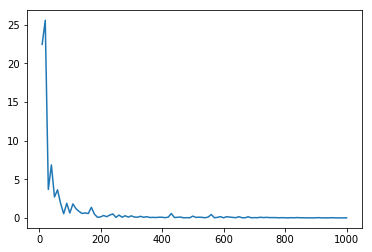

In [13]:
for epoch in range(0, train_number_epochs):
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = Variable(img0), Variable(img1) , Variable(label)
        distance = net(img0,img1)
        optimizer.zero_grad()
        loss_contrastive = criterion(distance,label)
        loss_contrastive.backward()
        optimizer.step()
        if i %10 == 0 :
            print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.data[0]))
            iteration_number +=10
            counter.append(iteration_number)
            loss_history.append(loss_contrastive.data[0])
show_plot(counter,loss_history)

## Some simple testing
The last 3 subjects were held out from the training, and will be used to test. The Distance between each image pair denotes the degree of similarity the model found between the two images. Less means it found more similar, while higher values indicate it found them to be dissimilar.

In [14]:
class SiameseNetworkDataset_Evaluation():
    
    def __init__(self, imageFolderDataset):
        self.imageFolderDataset = imageFolderDataset   
        self.images = np.array(list(map(list, self.imageFolderDataset.imgs)))
        self.ind = 0
        
    def __iter__(self):
        return self
        
    def next(self):
        img0_tuple = random.choice(self.images)
        img1_tuple = self.images[self.ind]
        self.ind += 1
        
        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        transform=transforms.Compose([transforms.Resize((100,100)),transforms.ToTensor()])
        
        img0 = transform(img0)
        img1 = transform(img1)
        return img0, img1, img0_tuple[1], img1_tuple[1]
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

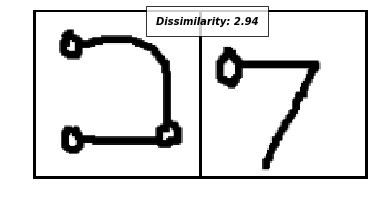

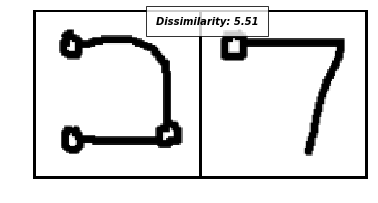

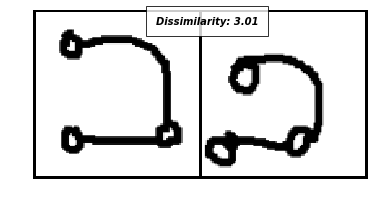

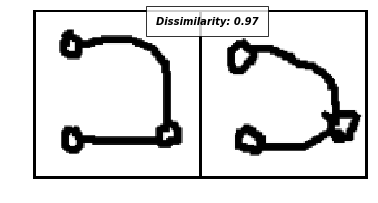

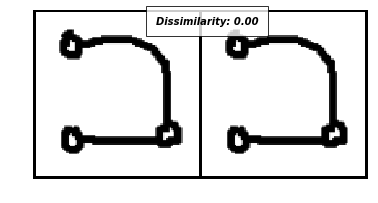

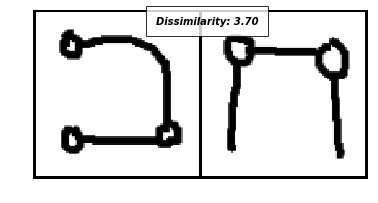

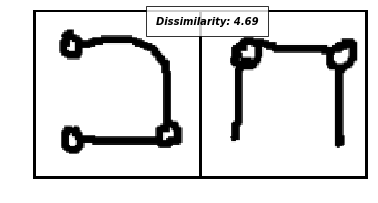

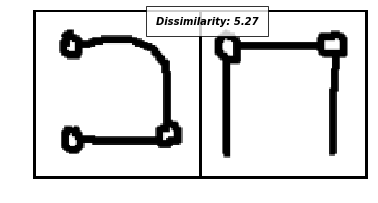

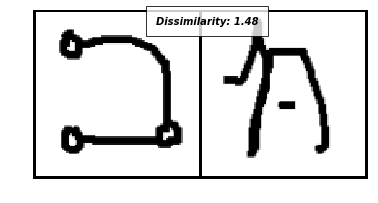

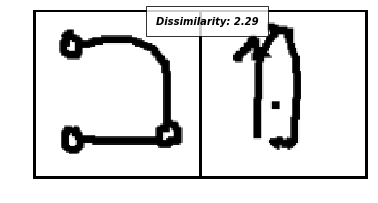

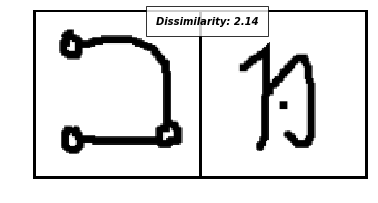

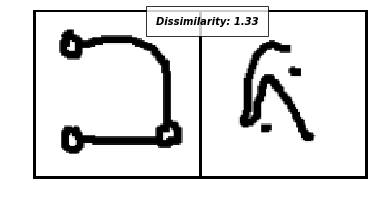

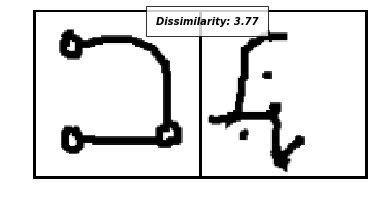

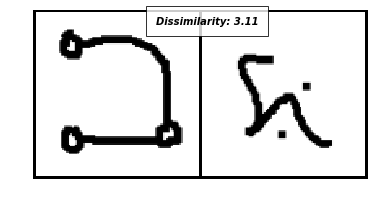

Accuracy:  0.8571428571428571


In [15]:
folder_dataset_test = dset.ImageFolder(root=testing_dir)
dataiter = SiameseNetworkDataset_Evaluation(imageFolderDataset=folder_dataset_test)

x0,_,x0_label, _= dataiter.next()



images = []
dissimilarity = []
x1_labels = []
for i in range(len(folder_dataset_test.imgs)-1):
    _,x1, _, x1_label = dataiter.next()
    x1_labels.append(x1_label)
    x0 = x0.view(1, 1, 100, 100)
    x1 = x1.view(1, 1, 100, 100)
    concatenated = torch.cat((x0,x1),0)
    euclidean_distance = net(Variable(x0),Variable(x1))
    images.append(torchvision.utils.make_grid(concatenated))
    dissimilarity.append(euclidean_distance.data.numpy()[0][0]) 
    imshow(images[i], 'Dissimilarity: {:.2f}'.format(dissimilarity[i]))
    
dissimilarity = np.array(dissimilarity)
x1_labels = np.a–rray(x1_labels)
score = 0
num_same = sum(x1_labels == x0_label)

pred_same = dissimilarity.argsort()[:num_same]
score += sum([0]*num_same == (x1_labels[pred_same] != [x0_label]*num_same))
num_diff = len(x1_labels) - num_same
pred_diff = dissimilarity.argsort()[num_same:]
score += sum([1]*num_diff == (x1_labels[pred_diff] != [x0_label]*num_diff))
print("Accuracy: ", score/len(dissimilarity))
